Initial explorations of calcium imaging data from V1DD dataset.
Same as `2025-09-01-explore-2p.ipynb`, but with helper functions factored out.

In [1]:
%load_ext autoreload
%autoreload 2

# general imports 
import os
from pathlib import Path
from pprint import pprint
from tqdm.auto import tqdm

import numpy as np
import scipy
import pandas as pd 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

# Add package to path
import sys
sys.path.insert(0, '/root/capsule/code/src')
from funcky.utils import load_nwb_session, get_aligned_session_data

In [2]:
# Specify data directory location
DATA_DIR = "/data/"  # Code Ocean

# Load metadata csv, which contains session, subject, column, and volume info
metadata = pd.read_csv('/root/capsule/metadata/V1DD_metadata.csv')

In [3]:
selected_session = metadata[
    (metadata['golden_mouse']==True)    # mouse with structural info
    & (metadata['column']==1)           # center imaging column
    & (metadata['volume']==3)           # not top or bottom volume
]

assert len(selected_session) == 1, f"Expected exactly 1 session, got {len(selected_session)}"

nwb = load_nwb_session(selected_session.name.item(), DATA_DIR)

/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.9.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [4]:
session_data = get_aligned_session_data(nwb)

/root/capsule/code/src/funcky/utils.py:94: UserWarning: Ignoring `remove_known_bad_planes`; not removing column 1, volume 5, plane 6)
  warnings.warn("Ignoring `remove_known_bad_planes`; not removing column 1, volume 5, plane 6)")


  0%|          | 0/6 [00:00<?, ?it/s]

/root/capsule/code/src/funcky/utils.py:161: UserWarning: pupil: 516 NaNs detected; fillin in via interpolation.
  warnings.warn(


## Evaluate response to `natural_images_12`

*Stimulus set description*
- A subset of 12 images from the 118 images of the Visual Coding stimulus set
- Images were presented in a frozen sequence, and repeated 40 times
- Images were switched at 3Hz. This accomodates the slower imaging rate of the DeepScope

In [5]:
stimulus_table = nwb.intervals['stimulus_table'].to_dataframe()

# ----------------------------------------------------------------
selected_stimulus = 'natural_images_12'
selected_stimulus_table = stimulus_table[stimulus_table['stim_name'] == selected_stimulus]

start_times = selected_stimulus_table[
    selected_stimulus_table['image_order'] == 0
]['start_time'].values
stop_times = selected_stimulus_table[
    selected_stimulus_table['image_order'] == 11
]['stop_time'].values

timestamps = session_data['timestamps']
start_indices = np.array(
    [np.nonzero(timestamps >= start_time)[0][0] for start_time in start_times]
)

stop_indices = np.array(
    [np.nonzero(timestamps <= stop_time)[0][-1]+1 for stop_time in stop_times]
)

assert len(start_indices)==40, f"Expected 40 start times, got {len(start_indices)}."
assert len(stop_indices)==40, f"Expected 40 stop times, got {len(stop_indices)}."

Text(0.5, 0.95, 'natural_images_12, first 10 presentations')

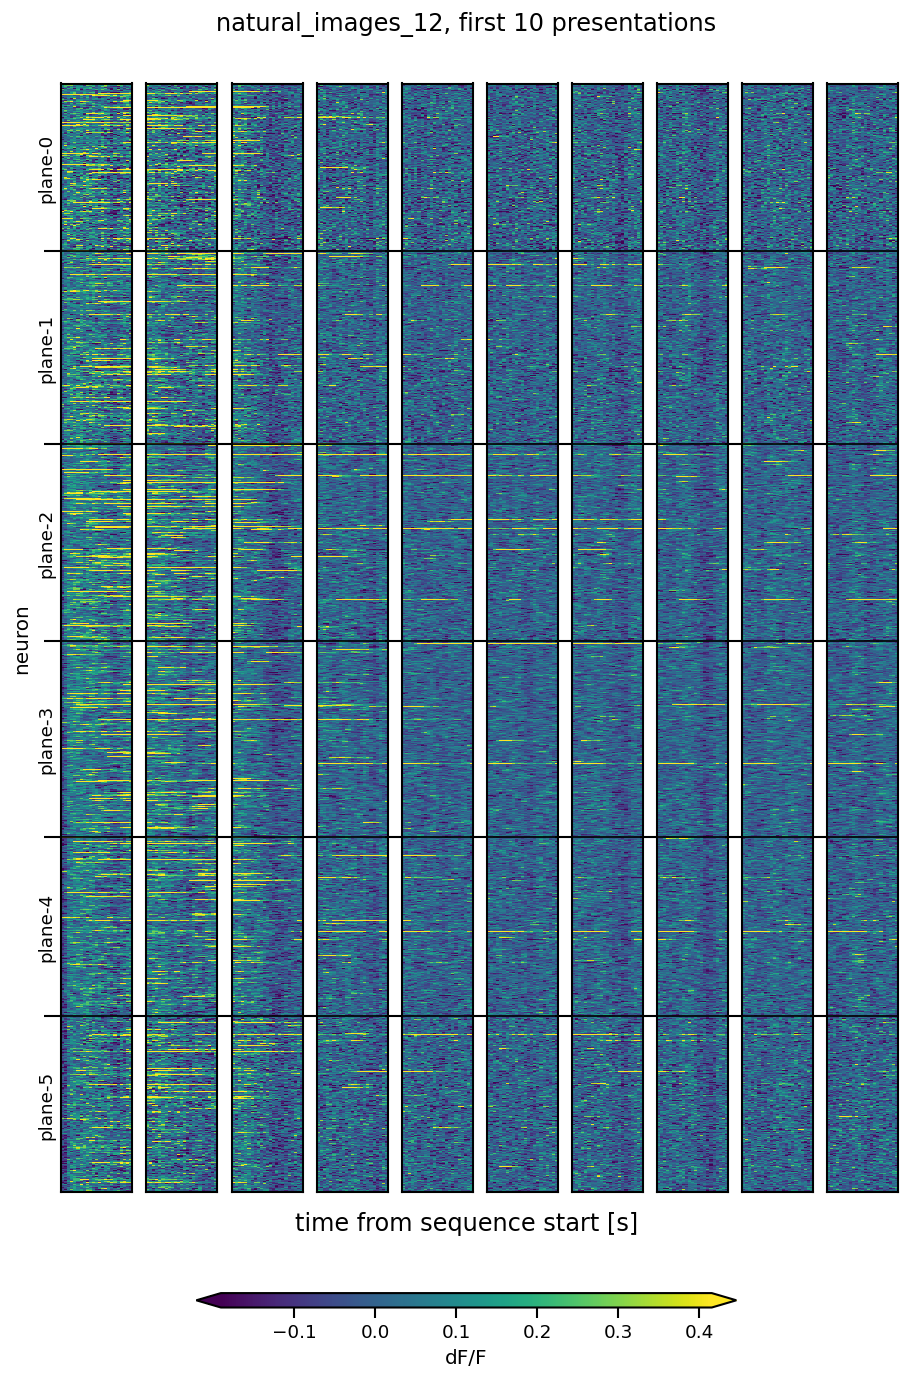

In [6]:
dff = session_data['dff_traces']
plane_ids = session_data['plane_ids']

# Set up drawing horizontal lines at every plane
plane_ids = session_data['plane_ids']
y_cluster_edges = np.nonzero(plane_ids[1:] - plane_ids[:-1])[0] + 1

y_cluster_centers = np.concatenate([
    [0.5*y_cluster_edges[0]],  # first cluster
    0.5*(y_cluster_edges[1:] - y_cluster_edges[:-1]) + y_cluster_edges[:-1],
    [0.5*(len(plane_ids) - y_cluster_edges[-1]) + y_cluster_edges[-1]]  # last cluster
])

y_cluster_labels = [f'plane-{plane_id}' for plane_id in np.unique(plane_ids)]

# Set color norm
norm = mpl.colors.Normalize(
    vmin=np.percentile(dff[:, start_indices[0]:stop_indices[-1]], 1),
    vmax=np.percentile(dff[:, start_indices[0]:stop_indices[-1]], 99),
)

fig, axs = plt.subplots(ncols=10, sharex=True,sharey=True, figsize=(9,12), dpi=120)
for ax, start_index, stop_index in zip(axs, start_indices, stop_indices):
    im = ax.imshow(
        dff[:,start_index:stop_index],
        norm=norm, interpolation='none', aspect='auto'
    )

    for edge in y_cluster_edges:
        ax.axhline(edge, color='k', lw=1)

    # Annotate y-axis with plane
    ax.set_yticks(y_cluster_edges)
    ax.tick_params(axis='y', labelleft=False, length=10)
    
    ax.set_yticks(y_cluster_centers, minor=True)
    ax.set_yticklabels(y_cluster_labels, minor=True, rotation=90, va='center',)
    ax.tick_params(axis='y', which='minor', left=False, length=0)
    
    # Hide x-axis ticks
    ax.tick_params(labelbottom=False, bottom=False)

    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel('neuron')

fig.supxlabel("time from sequence start [s]", y=0.10)

# Add color bar
fig.subplots_adjust(top=0.9, bottom=0.13)
cax = fig.add_axes((0.25,0.05, 0.5, 0.01))   # (l,b,w,h)
fig.colorbar(im, cax=cax, extend='both', label='dF/F', orientation='horizontal')

# Add title
fig.suptitle("natural_images_12, first 10 presentations", y=0.95)

## Load behavioral data

In [ ]:
# Process the traces a bit
from sklearn.preprocessing import StandardScaler

normd_behavior_traces = np.array([
    StandardScaler().fit_transform(traces.reshape(-1,1)).squeeze()
    for traces in session_data['behavior_traces']
])

print(f"Behavioral variables: {session_data['behavior_names']}")
print(f"{normd_behavior_traces.shape=}")

assert np.all(~np.isnan(normd_behavior_traces)), "There shouldn't be any nans in the behavioral traces"

Behavioral variables: ['running_speed' 'pupil']
normd_behavior_traces.shape=(2, 21616)


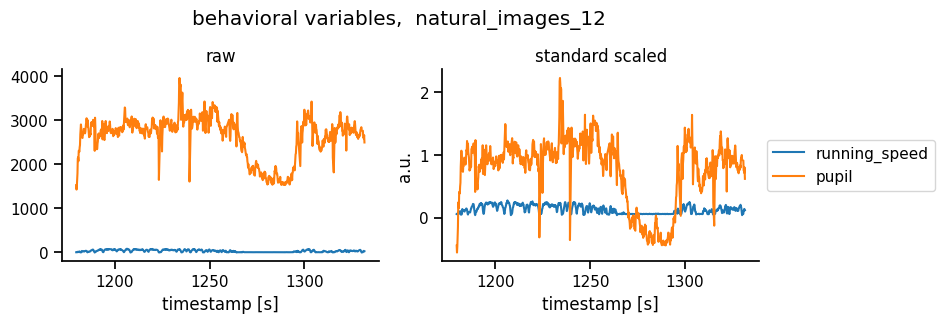

In [9]:
timestamps_ = session_data['timestamps'][start_indices[0]:stop_indices[-1]]
behavior_traces_ = session_data['behavior_traces'][:,start_indices[0]:stop_indices[-1]]
normd_behavior_traces_ = normd_behavior_traces[:,start_indices[0]:stop_indices[-1]]

behavior_names = session_data['behavior_names']

fig, axs = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(9,3))

for i, name in enumerate(behavior_names):
    # Plot raw versions
    ax = axs[0]
    ax.plot(timestamps_, behavior_traces_[i], label=name)
    ax.set_xlabel("timestamp [s]")

    # Plot standard scaled versions
    ax = axs[1]
    ax.plot(timestamps_, normd_behavior_traces_[i], label=name)
    ax.set_ylabel('a.u.')
    ax.set_xlabel("timestamp [s]")

axs[0].set_title('raw')    
axs[1].set_title('standard scaled')

# Add legend
axs[1].legend(loc='center left', bbox_to_anchor=(1,0.5))

fig.subplots_adjust(top=0.75,)
fig.suptitle("behavioral variables,  natural_images_12", y=0.95)
# fig.legend(lc, loc='center left', bbox_to_anchor=(1,0.5))
sns.despine()